In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from fxpmath import Fxp

try:
    import mpld3
    mpld3.enable_notebook()
except:
    print("Modul mpld3 is NOT installed.")

def plot_signal(x, x_label = "", y_label = "", title = "", show = True):
    """ Function that plots signal in Time domain. """
    plt.plot(x)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def plot_spectrum(x, x_label = "", y_label = "", title = "", dB = True, show = True):
    """ Function that plots signal in Frequency domain. """
    n = len(x)
    F = np.fft.fftshift(np.fft.fftfreq(n))
    X = np.fft.fftshift(abs(np.fft.fft(x)))
    if dB:
        X = 20 * np.log10(X)
        X -= np.max(X)
    plt.plot(F, X)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def plot_sonar(x, fs, c, slope, title="", show=True, **kwargs):
    n = len(x)
    F = np.fft.fftfreq(n)
    dist = F * fs * c / 2 / slope
    dist = dist[:n//2]
    X = abs(np.fft.fft(x))[:n//2]
    X_dB = 20 * np.log10(X)
    X_dB -= np.max(X_dB)
    # Threshold value
    th = -10
    # Find peaks above the threshold
    peaks, _ = signal.find_peaks(X_dB, height=th)
    # Convert indices to distances 
    distance_peaks = np.array(peaks) / n * fs * c / 2 / slope

    # fig = plt.figure(figsize=(6, 4))
    plt.plot(dist, X_dB)
    plt.plot(distance_peaks, X_dB[peaks], "x")
    # Annotate each peak with its distance
    for i, peak in enumerate(distance_peaks):
        plt.annotate(f'{peak:.2f} m', (peak + 0.3, X_dB[peaks][i]))
    plt.xlabel("Distance [m]")
    plt.ylabel("|X| dB")
    # plt.title(title if title else f"Spectrum of TX and RX channel product, fs = {round(fs / D / 1e3)} kHz")
    plt.title(title)
    plt.ylim([min(X_dB), 10])
    
    if show:
        plt.show()

def plot_FIR(fir_coeff, x_label = "", y_label = "", title = "", show = True):
    """ Function that plots FIR impulse response in dB. """
    w, h = signal.freqz(fir_coeff)
    H = 20 * np.log10(abs(h))
    plt.plot(w / (2 * np.pi), H)
    plt.plot([1 / (2 * D) - transition_width, 1 / (2 * D) - transition_width], [np.min(H), 0], "r--")
    plt.plot([1 / (2 * D), 1 / (2 * D)], [np.min(H), 0], "r--");
    plt.plot([1 / (2 * D) + transition_width, 1 / (2 * D) + transition_width], [np.min(H), 0], "r--")
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def stem_FIR(x, x_label = "", y_label = "", title = "", show = True):
    """ Function that stems FIR's coeffitients. """
    plt.stem(x)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def gen_FIR(n_FIR, D, transition_width):
    """ Function that generates FIR coeffitients based on number of coeffitients and transititon zone. """
    fir_response = [1.0, 1.0, 0.0, 0.0]
    fir_freqs = [0.0, 1 / (2 * D) - transition_width, 1 / (2 * D) + transition_width, 0.5]
    fir_coeff = signal.firls(n_FIR, fir_freqs, fir_response, fs = 1)
    return fir_coeff

def gen_FIR_opt(n_FIR, D, ripple, attenuation, transition_width, symetric = True):
    """ Function that generates FIR coeffitients based on ripple in pass band and attenuation in non-passed band. """
    num_taps = n_FIR
    fir_response = [1.0, 1.0, 0.0, 0.0]
    fir_freqs = [0.0, 1 / (2 * D) - transition_width, 1 / (2 * D) + transition_width, 0.5]
    if not symetric:
        fir_freqs[2] = 1 / (2 * D)
        
    while(True):
        fir_coeff = signal.firls(num_taps, fir_freqs, fir_response, fs = 1)
        w, h = signal.freqz(fir_coeff)
        H = 20 * np.log10(abs(h))
        ripple_ = np.max(H[:int(len(H) * 2*fir_freqs[1])]) - np.min(H[:int(len(H) * 2*fir_freqs[1])])
        attenuation_ = np.max(H[int(len(H) * 2*fir_freqs[2]):])
        if(ripple_ <= ripple and -attenuation_ >= attenuation):
            break
        else:
            num_taps += 2
    return fir_coeff

def gen_test_spectrum(n, freq, amp, rand_phase = False):
    ''' Generate test spectrum
         Arguments:
            n    - number of samples
            freq - tuple of digital frequencies (startFreq, endFreq) in range (0, 0.5)
            amp  - tuple of amplitudes (ampStart, ampEnd)
            randPhase - if True, assign random phase to each sample '''
    freq_start, freq_end = freq
    amp_start, amp_end = amp
    ind_start = round(n * freq_start)
    ind_end = round(n * freq_end)
    x = np.zeros(n, dtype = "complex128")
    x[ind_start : ind_end] = amp_start - np.linspace(0, 1, num = ind_end - ind_start) * (amp_start - amp_end)
    if rand_phase:
        x[ind_start : ind_end] *= np.exp(1j * 2 * np.pi * np.random.rand(ind_end - ind_start))
    x[0] = abs(x[1]) / 2

    x_time_domain = np.fft.ifft(x)
    return x_time_domain


In [2]:
# def fir_direct_fxp(x, h, state = None, outFxpFormat = None):
#     M = len(h)
#     N = len(x)
#     if state == None:
#         delayLine = Fxp(np.zeros(M), like = x) # like = x, kaze da je format delayLine-a isti kao i format x-a
#     else:
#         delayLine = state
    
#     if outFxpFormat == None:
#         y = Fxp(np.zeros(N), signed = True, n_word = x.n_word + h.n_word + int(np.ceil(np.log2(M))), n_frac = x.n_frac + h.n_frac)
#     else:
#         y = Fxp(np.zeros(N), dtype = outFxpFormat)
    
#     y.overflow = x.overflow
#     y.rounding = x.rounding
    
#     for n in range(N):
#         delayLine[1:] = delayLine[:-1]
#         delayLine[0] = x[n]
#         sumVal = Fxp(0, like = delayLine[0]*h[0])
#         for m in range(M):
#             sumVal += h[m]*delayLine[m]
#         y[n] = Fxp(sumVal, like = y)
    
#     return y

def fir_direct_fxp(x, h, state = None, out_fxp_format = None):
    N = len(x)
    M = len(h)

    delay_line = np.zeros(M)

    y_ = []
    for n in range(N):
        delay_line[1:] = delay_line[:-1]
        delay_line[0] = x[n]()
        acc = 0
        for m in range(M):
            tmp = Fxp((delay_line[m] * h[m]()), signed = x.signed, n_word = 32, n_frac = 30)
            tmp.rounding, tmp.overflow = x.rounding, x.overflow
            acc += tmp()
        y_.append(acc)
        y = Fxp(y_, signed = x.signed, n_word = x.n_word, n_frac = x.n_frac)
        y.rounding, y.overflow = x.rounding, x.overflow
    return y_

# class FixedPoint:
#     def __init__(self, value, n_word, n_frac):
#         self.frac = n_frac
#         self.word = n_word
#         self.int = n_word - n_frac
#         self.res = 2**-self.frac
#         self.max_val = (2**(self.int - 1)) - self.res
#         self.min_val = -2**(self.int - 1)

#         # Scale the value to integer representation
#         scaled_value = value * 2**n_frac

#         # Wrap instead of truncate
#         wrap_range = 2**n_word
#         self.value = int(scaled_value) % wrap_range
#         if self.value >= 2**(n_word - 1):
#             self.value -= 2**n_word

#     def get_val(self, dtype=None):
#         if dtype is None:
#             val = self.value / 2**self.frac
#         elif dtype == "int":
#             val = self.value
#         return val

#     def get_frac(self):
#         return self.frac

#     def get_word(self):
#         return self.word
    
#     def info(self):
#         print(f"Format: s{self.word}/{self.frac}")

#     def __str__(self):
#         return f"{self.get_value():.{self.frac}f}"

#     def __add__(self, other):
#         if self.frac != other.frac:
#             raise ValueError("Decimal places must be the same for both numbers")
#         result_value = self.value + other.value
#         return FixedPoint(result_value / 2**self.frac, self.int + self.frac, self.frac)

def write_to_file(x, file):
    with open(file, 'w') as file:
        # file.write(str(len(x)) + '\n')
        for i in range(len(x)):
            if i < len(x) - 1:
                file.write(str(x[i].val) + '\n')
            else:
                file.write(str(x[i].val))

def write_to_file_(x, file):
    with open(file, 'w') as file:
        for i in range(len(x)):
            if i < len(x) - 1:
                file.write("x\"" + str(x[i].hex()[2:]) + "\",\n")
            else:
                file.write("x\"" + str(x[i].hex()[2:]) + "\"")

def read_from_file(file):
    y = np.loadtxt(file)
    return y
            

# def fir_direct_fxp(x, h):
#     M = len(h)
#     N = len(x)
    
#     delay_line = np.zeros(M)
#     y = []

#     n_word = x[0].get_word() + h[0].get_word() + int(np.ceil(np.log2(M)))
#     n_frac = x[0].get_frac() + h[0].get_frac()

#     for n in range(N):
#         delay_line[1:] = delay_line[:-1]
#         delay_line[0] = x[n].get_val()
#         acc = FixedPoint(0, n_word, n_frac)
#         for m in range(M):
#             tmp = FixedPoint(delay_line[m] * h[m].get_val(), n_word, n_frac)
#             acc = acc + tmp
#         y.append(acc.get_val('int'))
#         # y.append(FixedPoint(acc.get_val(), n_word, n_frac).get_val("int"))
#     print(acc.info())
#     return y

In [3]:
n = 32
overFlowMethod = 'wrap'
roundingMethod = 'fix'
n_word = 16
n_frac = 15
D = 2

tst = Fxp(None, signed = True, n_word = n_word, n_frac = n_frac, overflow = overFlowMethod, rounding = roundingMethod)

F1 = 0.1
F2 = 0.43

test_file = r'..\test_signal.txt'
coeff_file = r'..\fir_coeff.txt'
result_file = r'..\fir_test_signal.txt'

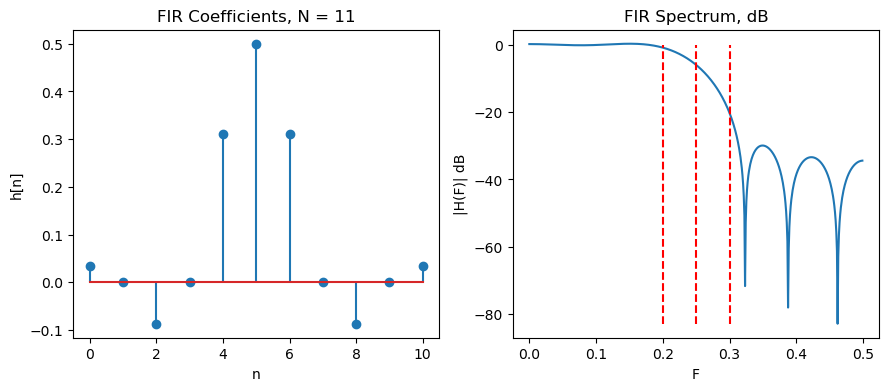

In [4]:
n_FIR = 1
ripple = 2
attenuation = 10 # in dB
transition_width = 0.05
# fir_coeff = gen_FIR_opt(n_FIR, D, ripple, attenuation, transition_width, symetric = True)
fir_coeff = gen_FIR(11, D, transition_width)
h_Fxp = []
# for i in range(len(fir_coeff)):
#     h_Fxp.append(FixedPoint(fir_coeff[i], n_word, n_frac))
h_Fxp = Fxp(fir_coeff, like = tst)
h_Fxp.overflow, h_Fxp.rounding = tst.overflow, tst.rounding

write_to_file_(h_Fxp, coeff_file)


figH = 4
ax_x = 1; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.6 * figH, 1 * figH))
plt.subplot(ax_x, ax_y, 1)
stem_FIR(fir_coeff, 'n', 'h[n]', f"FIR Coefficients, N = {len(fir_coeff)}", show = False)
plt.subplot(ax_x, ax_y, 2)
plot_FIR(fir_coeff, 'F', '|H(F)| dB', "FIR Spectrum, dB", show = False)

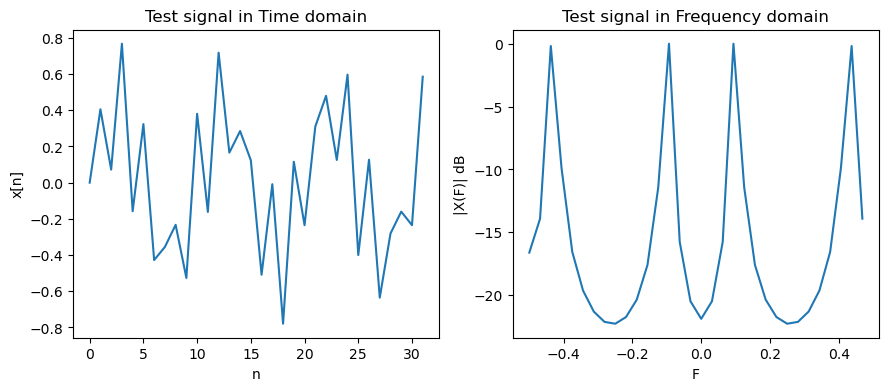

In [5]:
x = 0.4 * (np.sin(2*np.pi*F1*np.arange(n)) + np.sin(2*np.pi*F2*np.arange(n)))
x_per = np.concatenate((x, x[:len(fir_coeff)]))
# x_per_Fxp = []
# for i in range(len(x_per)):
#     x_per_Fxp.append(FixedPoint(x_per[i], n_word, n_frac))
x_per_Fxp = Fxp(x_per, like = tst)
x_per_Fxp.overflow, x_per_Fxp.rounding = tst.overflow, tst.rounding

write_to_file(x_per_Fxp, test_file)

figH = 4
ax_x = 1; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.6 * figH, 1 * figH))
plt.subplot(ax_x, ax_y, 1)
plot_signal(x, 'n', 'x[n]', "Test signal in Time domain", show = False)
plt.subplot(ax_x, ax_y, 2)
plot_spectrum(x, 'F', '|X(F)| dB', "Test signal in Frequency domain", show = False)

In [6]:
y = fir_direct_fxp(x_per_Fxp, h_Fxp)

In [7]:
c = Fxp(y, True, 16, 15)
c.overflow, c.rounding = tst.overflow, tst.rounding
c = Fxp(y, True, 16, 15)
print(c)

[ 0.          0.01412964  0.00250244 -0.00845337 -0.01177979  0.07080078
  0.22396851  0.3611145   0.3862915   0.23846436  0.00656128 -0.23623657
 -0.37536621 -0.37286377 -0.23822021  0.00775146  0.22421265  0.38275146
  0.37149048  0.23330688  0.00250244 -0.237854   -0.36828613 -0.3840332
 -0.22518921 -0.00479126  0.23382568  0.37789917  0.3706665   0.23965454
 -0.00814819 -0.22494507 -0.38043213 -0.38595581 -0.22854614  0.04788208
  0.23660278  0.24505615  0.23461914  0.30459595  0.37808228  0.25891113
  0.00656128]


In [8]:
y_ = read_from_file(result_file)
print(y_*2**-15)

FileNotFoundError: ..\fir_test_signal.txt not found.

In [ ]:
plt.plot(y_[1:])
plt.plot(np.array(y[:-1])*2**30)

# print((y_[1:] - y.val[:-1]))

In [ ]:
print(h_Fxp.hex())

In [ ]:
class FixedPoint:
    def __init__(self, value, n_word, n_frac):
        self.frac = n_frac
        self.int = n_word - n_frac
        self.res = 2**-self.frac
        self.max_val = (2**(self.int - 1)) - self.res
        self.min_val = -2**(self.int - 1)

        # Scale the value to integer representation
        scaled_value = value * 2**n_frac

        # Wrap instead of truncate
        wrap_range = 2**n_word
        self.value = int(scaled_value) % wrap_range
        if self.value >= 2**(n_word - 1):
            self.value -= 2**n_word

    def get_value(self, dtype=None):
        if dtype is None:
            val = self.value / 2**self.frac
        elif dtype == "int":
            val = self.value
        return val

    def info(self):
        print(f"Format: s{self.int+self.frac}/{self.frac}")

    def __str__(self):
        return f"{self.get_value():.{self.frac}f}"

    def __add__(self, other):
        if self.frac != other.frac:
            raise ValueError("Decimal places must be the same for both numbers")
        result_value = self.value + other.value
        return FixedPoint(result_value / 2**self.frac, self.int + self.frac, self.frac)

    # def __mul__(self, other):
    #     if self.frac != other.frac:
    #         raise ValueError("Decimal places must be the same for both numbers")
    #     result_value = (self.value * other.value) // 2**self.frac
    #     return FixedPoint(result_value / 2**self.frac, self.int + self.frac, self.frac)

# Example usage
n_word = 7  # 4 bits for the integer part and 4 bits for the fractional part
n_frac = 6

a = FixedPoint(0.5, n_word, n_frac)
b = FixedPoint(0.125, n_word, n_frac)
c = a + b
d = FixedPoint(a.get_value() * b.get_value(), n_word, n_frac)

print(a.get_value("int"), b.get_value("int"))
print(c.get_value())
print(d.get_value())


In [ ]:
def fir_direct_ftp(x, h, state = None):
    N = len(x)
    M = len(h)

    if state == None:
        delay_line = np.zeros(M)
    else:
        delay_line = state

    y = np.zeros(N)
    for n in range(N):
        delay_line[1:] = delay_line[:-1]
        delay_line[0] = x[n]
        acc = 0
        for m in range(M):
            acc += delay_line[m] * h[m]
        y[n] = acc
    return y

def fir_direct_fxp(x, h, state = None, out_fxp_format = None):
    N = len(x)
    M = len(h)

    delay_line = np.zeros(M)

    y_ = []
    for n in range(N):
        delay_line[1:] = delay_line[:-1]
        delay_line[0] = x[n]()
        acc = 0
        for m in range(M):
            tmp = Fxp((delay_line[m] * h[m]()), signed = x.signed, n_word = x.n_word + h.n_word, n_frac = x.n_frac + h.n_frac)
            acc += tmp
        y_.append(acc)
        y = Fxp(y_, signed = x.signed, n_word = x.n_word, n_frac = x.n_frac)
    return y


In [ ]:
n_word = 4
n_frac = 3
overFlowMethod = 'wrap'
roundingMethod = 'trunc'

In [ ]:
h_ftp = np.array([-2.63665205e-17, 3.06687619e-01, 5.00000000e-01, 3.06687619e-01, -2.63665205e-17])
h_fxp = Fxp(h_ftp, signed = True, n_word = n_word, n_frac = n_frac)
h_fxp.overflow = overFlowMethod
h_fxp.rounding = roundingMethod


print(h_ftp)
print(h_fxp)
# print(h_fxp.info(3))

for i in range(len(h_fxp)):
    print(f"x\"{h_fxp[i].hex()[2:]}\",")

In [ ]:
n = 8
F1 = 0.1
F2 = 0.43
x_ftp = 0.4 * (np.sin(2*np.pi*F1*np.arange(n)) + np.sin(2*np.pi*F2*np.arange(n)))
x_fxp = Fxp(x_ftp, signed = True, n_word = n_word, n_frac = n_frac)
x_fxp.overflow = overFlowMethod
x_fxp.rounding = roundingMethod

print(x_ftp)
print(x_fxp)
# print(x_fxp.val)

In [ ]:
y_ftp = fir_direct_ftp(x_ftp, h_ftp)
y_fxp = fir_direct_fxp(x_fxp, h_fxp)
# y_fxp = np.array(y_fxp)
print(y_fxp.val)

# print('')
# print(y_ftp)
# print(y_fxp*2**3)

In [ ]:
y_vhdl =  np.loadtxt(r'..\fir_test_signal.txt')
print(y_vhdl)

In [ ]:
2.24861063e-01 * 2**3

In [ ]:
plt.plot(y_python.val);
plt.plot(y_vhdl);

In [ ]:
print(f"x_fxp = {x_fxp}")
print(f"h_fxp = {h_fxp}")

In [ ]:
delay_line_0 = np.array([0., 0., 0., 0., 0.])
delay_line_1 = np.array([0.375, 0.,    0.,    0.,    0.   ])
delay_line_2 = np.array([0.,    0.375 ,0. ,   0.  ,  0.   ])
delay_line_3 = np.array([0.75,  0.,    0.375 ,0.  ,  0.   ])
delay_line_4 = np.array([-0.125,  0.75 ,  0. ,    0.375 , 0.   ])
delay_line_5 = np.array([ 0.25,  -0.125,  0.75 ,  0.    , 0.375])
delay_line_6 = np.array([-0.375 , 0.25,  -0.125 , 0.75  , 0.   ])
delay_line_7 = np.array([-0.25 , -0.375 , 0.25 , -0.125 , 0.75 ])
delay_line = np.array([delay_line_0, delay_line_1, delay_line_2, delay_line_3, delay_line_4, delay_line_5, delay_line_6, delay_line_7])

y = np.zeros(8)
y_fxp = np.zeros(8)
for i in range(8):
    y[i] = np.dot(delay_line[i], h_fxp())
    y_fxp[i] = Fxp(y[i], signed = True, n_word = n_word, n_frac = n_frac)

y_fxp_2 = Fxp(y, signed = True, n_word = n_word, n_frac = n_frac)
print(y)
print(y_fxp)
print(y_fxp_2.val)

In [ ]:
y_vhdl =  np.loadtxt(r'..\fir_test_signal.txt')
print(y_vhdl)

In [ ]:
(3*4 + 13*5)/16

In [ ]:
(2*4+11*5)/13